# **Lesson 2, Random Forests Hyperparameters and tunning**
http://course18.fast.ai/lessonsml1/lesson2.html

## **Code from lesson 1 from Intrto Machine Learning from Fast AI:**

In [0]:
#You can edit source code from modules and they will update accordingly
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
#Needed imports
import sys
from fastai.imports import *
from fastai.tabular import *

sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/L1RF')
from structured import *

# pandas???
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [0]:
PATH = 'gdrive/My\ Drive/Colab\ Notebooks/L1RF/data/'

In [0]:
# Parse and store the data using a panda funtion, passing the path and a list of all the date columns
PATH = PATH.replace("\\", "")
data_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [0]:
#Simple display function
def display_all(df):
  with pd.option_context("display.max_rows", 1000):
    with pd.option_context("display.max_columns", 1000):
      display(df)

In [0]:
display_all(data_raw.tail()) #displays the last few items from our table

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,35NX2,35,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric...",Maryland,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401124,6333342,7750,1926965,21435,149,2.0,2005,NaN,NaN,2011-10-25,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric...",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


Since we want to predict the price the column that matters the most to us is 'SalePrice'
This is called our dependent variable

Here the evaluation is evaluated on the **root mean squared log error** which means they will look at the difference between the log of the prediction of the price and the log of the actual price of the test set, they'll square that and add it up.
https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

This is a very good measuement for prices since the error is meassured relative to the quantity due to logarithm properties.

In [0]:
display(data_raw.SalePrice)

0         66000
1         57000
2         10000
3         38500
4         11000
          ...  
401120    10500
401121    11000
401122    11500
401123     9000
401124     7750
Name: SalePrice, Length: 401125, dtype: int64

In [0]:
#since we are very interested in the logarithm of the data then we convert this price row to its logarithm using numpy
data_raw.SalePrice = np.log(data_raw.SalePrice)
display(data_raw.SalePrice)

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
401120     9.259131
401121     9.305651
401122     9.350102
401123     9.104980
401124     8.955448
Name: SalePrice, Length: 401125, dtype: float64

**Lest create a Random Forest!!!**

A **Random Forest** is a kind of universal ML technique. It can predict categorical(discrete) or continious varioables (this is our case). In general it doesn't overfit and something cool is that it can tell you how well it generalizes without a validation set (test set). It has few if any statistical assumptions which is cool cause it's not very biased.

Another important thing is that there are two predictor types:
* Continious : Regressor **we are using this one**
* Categorical : Classifier

In [0]:
#This data set contains categorical and continious variabels and our model only likes numbers
#Hence we have to change our data frame to use numbers

#First thing to change is the dates.
#For dates we can add more columns to our data since some stuff may add more meaning to our dependent variable
#This will be categorical values represented as numbers about certain date facts that may be useful (also, it removes the original column)

add_datepart(data_raw, 'saledate')

In [0]:
data_raw.columns #prints the colums of our data frame

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [0]:
#We create a categorical value for everything that's a string (after changing the dates)
#train_cats maps converts strings to categorical variables for all columns
train_cats(data_raw)

In [0]:
#For this column we should reorder this categorie from h l m to h m l this is due to the decision
#tree formed by the random forest, also -1 are NA in the codes (we'll add one to normalize this)
data_raw.UsageBand.cat.categories
data_raw.UsageBand.cat.codes

data_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [0]:
#This function displays the percentage of null values in the dataset
display_all(data_raw.isnull().sum().sort_index()/len(data_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [0]:
#We can save the current table to disk with the follwing lines (it's stored efficently as the ram stores it)
os.makedirs('tmp', exist_ok=True)
data_raw.to_feather('tmp/raw')
#We can now just read our data from there
data_raw = pd.read_feather('tmp/raw')

In [0]:
#Lest now normalize the whole table
#This will basically first create a new column for all the columns which contain at least
#one NA and then set to 1 or 0. Then for every NA it will set the median.

#For the categories it will just add 1 and change it to it code(numerical) value we created in the past.

df, y, nas = proc_df(data_raw, 'SalePrice')

In [0]:
#SalePrice column is no longer there
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [0]:
#Everything is a number now
#Note we are not removing Ids as dimensions for our model, this is since Random Forests dont
#React significantly regarding that kind of stuff
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,41,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,55,98,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,0,45,0,6,8,44,4,4,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,0,0,0,0,40,32,3,3,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200,False,False


In [0]:
#We create the FIRST but NOT last model, the parameter n_jobs is tellin this to create the model using as many cores as possible
model = RandomForestRegressor(n_jobs=-1)
#We fit the model the data we want. (independent, dependent) variables as parameters
#model.fit(data_raw.drop('SalePrice', axis=1), data_raw.SalePrice)
model.fit(df, y)
model.score(df, y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9831434955436872

This error is r^2 (the closer to 1 the better) [-oo, 1]

In [0]:
#Here we will split into the last 12,000 rows of our table and use that for the validation set
#And the rest for training

def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(data_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [0]:
# lets define the RMSE root mean squeared error

def rmse(x, y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
  res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), m.score(X_train, y_train), m.score(X_valid, y_valid)]
  if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
  pre = ["RMSE training: ", "RMSE validation: ", "R^2 training: ", "R^2 validation: ", "OOB_SCORE: "]

  for i in range(len(res)):
    print(pre[i] + str(res[i]))

In [0]:
#We reset our model with our training data
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 43s, sys: 119 ms, total: 1min 43s
Wall time: 52.7 s
RMSE training: 0.09033870322229169
RMSE validation: 0.2483661016851665
R^2 training: 0.9829437901629704
R^2 validation: 0.8898377961827018


## **Lesson 2: Hyperparameters and tunning**

### **Speed things up**
Let's see how we can speed thing up for faster analysis.

In [0]:
#Lets take a smaller subset of only 30000 rows instead of all which area ~500,000
#The reason we are doing this is to speedup the runs ~9 seconds
df_trn, y_trn, nas = proc_df(data_raw, 'SalePrice', subset=30000, na_dict=nas)
#Note we don't update our validation set, that one will still be the big one we created previously
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [0]:
#Lets recreate our model
model = RandomForestRegressor(n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 4.21 s, sys: 13.9 ms, total: 4.22 s
Wall time: 2.27 s
RMSE training: 0.11230636559427173
RMSE validation: 0.36426189486537586
R^2 training: 0.9726615863460334
R^2 validation: 0.763039772107647


### **Hyperparameters**

Lets start adding hyperparameters and tunning our model.

* n_estimators: how many trees we want our forest to have.
* max_depth: the maximum depth of our tree, by default this is when each leaf node has exactly 1 giving us a perfect (extremely overfitted) model.
* bootrstrap: true if there exists randomization in our estimators, false otherwise. What scikit-learn does by default is for n rows, it picks out n rows with replacement — which is called bootstrapping
* n_jobs: if it's -1 we want to use several cores for our model


In [0]:
model = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

RMSE training: 0.5293450603159572
RMSE validation: 0.5790577767201898
R^2 training: 0.39264544369482735
R^2 validation: 0.40118624035887246


#### **Estimator (Tree) structure**
Here we have 4 values per each desition note.

* Splitting variable: This is the variable for which we are deciding to make our split (binary desition).
</br>This is decided by trying to separate our 2 groups into groups as homogeneous as possible within themselves and heterogeneous as possible with each other. Matemathically we make this desition by testing all the possible split variables with all possible binary resolution values and evaluate them according to their weighted average on the MSE. Whichever has the lowest is the best split and we use that one.

* MSE: Simply the MSE if we predict the value for all the samples in this node.
* Samples: The number of samples that fit this citeria.
* Value: The average value of all the samples in this node.

We should note that in the first node is the most naive model possible (predicting the average) which causes an R^2 of 0.

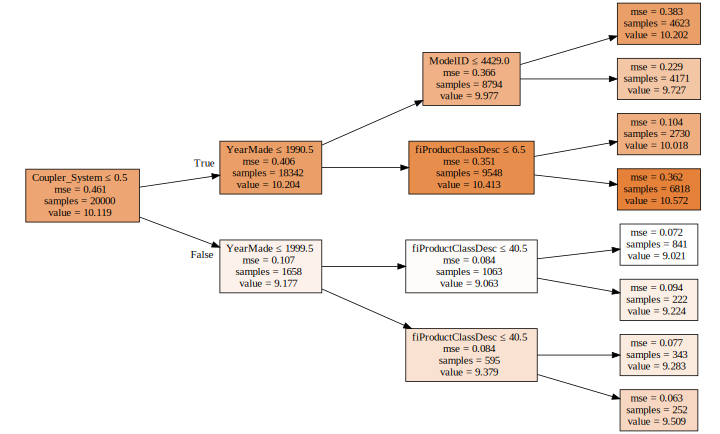

In [0]:
#Lets make a drawing of this samll estimator (tree) from our random forest.
draw_tree(model.estimators_[0], df_trn, precision=3)

In [0]:
t_df = X_train.copy()
t_df['value'] = y_train

In [0]:
#Simple verification of values = mean of subset in predictor node
a = t_df[t_df.Coupler_System<=0.5]
a = a[a.YearMade<=1985.5]
a = a[a.ModelID<=4157.5]
a ['value'].mean()

10.109815479603075

In [0]:
#Simple bigger tree
model = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

RMSE training: 6.526751786450488e-17
RMSE validation: 0.5182996655131075
R^2 training: 1.0
R^2 validation: 0.5202556915200415


### **Bagging**

Bagging helps us create a model using randomization.

What if we created N different un-correlated models somewhat predictive?
Each model will find different insights into the data and if we take the average (Ensemmbling) of all those overfitting predictors we will reduce our error to 0 as N increases (average of random errors) as long as all sets for predictors are picked randomly and their errors are unrelated.

The way this works is that the model (in sklearn) takes a random number of rows of our data frame (with replacement) for every predictor (by default 10 predictors [the more we can use, the better]) and uses those. It's important to note that the sets of each predictor may overlap each predictor covering ~65% of the total data in average.

Also recent research has shown that un-correlation is better than presition in the trees we create.

Sklear has another class named "ExtraTreesRegresor" which is an extremely randomized trees model which does the same as the RandomForestRegressor but now instead of checking for all splits of all variables it only tries a few of randomly selected splits for every node in each tree (predictor).

How much subsamples do we end up having per tree?

According to sklearn's api:
"The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)"

In [0]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)
print_score(model)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE training: 0.11260103424427118
RMSE validation: 0.3518598268948615
R^2 training: 0.9725179374666021
R^2 validation: 0.7789007123307042


In [0]:
#Here we are taking all trees and predicting the validation set on all of them.
#And we store that as a matrix of 10 by 12000 (validation test rows) in preds.
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
#We print the first 10 prediction, then their mean and finally the valid one
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([9.076809, 9.047821, 9.546813, 9.259131, 9.21034 , 9.10498 , 9.047821, 9.350102, 9.076809, 9.903488]),
 9.262411408358513,
 9.104979856318357)

In [0]:
preds.shape

(10, 12000)

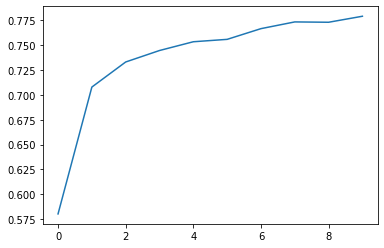

In [0]:
#Here we go through each of the 10 trees, take the mean of all of the predictions up to the ith trees
#finally we plot the r^2
#We can see it significantly improving as the number of trees grows
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

###**Out-of-bag (OOB) score**
Sometimes our data set will be a bit small and you dont want to pull out a validation set since that will mean our model with get crappier since the training data will be pretty small. WWYD? Theres a cool trick pretty much unique to random forests which is realizing that some of our rows didn't get used for some of our predictors so you can take those rows and pass it to the trees in which they don't appear and use that as your validation set. To calculate our preditction we will basically take every
row, see where it doesn't appear and average those trees.


In [0]:
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

RMSE training: 0.09586371938171373
RMSE validation: 0.3393560960249918
R^2 training: 0.9800807439410809
R^2 validation: 0.7943355236681334
OOB_SCORE: 0.857314511625867


In [0]:
from random import randrange

xd = []

for i in range(1000):
  xd.append(False)

for i in range(1000):
  x = randrange(1000)
  xd[x] = True

count = 0
for i in range(1000):
  if(xd[i]):
    count = count+1

print(count/1000)

0.639


###**Grid Search**

Basically a Sklearn function that allows us to pass all the parameters we want to try with a list of all the values we want to choose. Then this GridSeatch will try all the combinations and with that it will choose the best combination model.

### Defined Sub-sampling
Previously we selected our data to be of size 30000 and we are bootstraping over such set but, why dont we just program our model to instead look into all the dataframe but just take 30000 samples per each predictor?

In [0]:
#Lets resample our data frame
df_trn, y_trn, nas = proc_df(data_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
df_trn.shape

(401125, 66)

In [0]:
#Lets set the samples we want
set_rf_samples(20000)

In [0]:
#Now it will run as fast as before but with a wider data set
model = RandomForestRegressor(n_estimators=40, n_jobs=-1)
%time model.fit(X_train, y_train)
print_score(model)

CPU times: user 32.4 s, sys: 154 ms, total: 32.5 s
Wall time: 17 s
RMSE training: 0.22688377908900334
RMSE validation: 0.2626530974859391
R^2 training: 0.8924174780338769
R^2 validation: 0.8767993419133404


In [0]:
#Lets reset it back to normal
reset_rf_samples()

###**Grow trees less deep**
Another way to reduce overfitting is to reduce the deepness of our trees. We can do this by specifing min_samples_leaf

In [0]:
#Go back to reduced data
df_trn, y_trn, nas = proc_df(data_raw, 'SalePrice', subset=20000)
X_train, _ = split_vals(df_trn, n_trn)
y_train, _ = split_vals(y_trn, n_trn)

In [0]:
#Min_samples_leaf tells each predictor to stop a node when it has 3 or less samples in it (betweeen 1 and 25 usually)
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

RMSE training: 0.1444968071265672
RMSE validation: 0.26898993888890316
R^2 training: 0.95621869164637
R^2 validation: 0.8707828831895218
OOB_SCORE: 0.8430681626524317


###**Setup maximum number of features**
The less correlated your trees are, the better. Hence taking a different subset of columns every time we create a split will allow us to increase the un-correlation of the predictors.

In [0]:
#Max_features is a precentage of how much features we are comparing when selecting a split in a node of our predictor
model = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
model.fit(X_train, y_train)
print_score(model)

RMSE training: 0.14815866526275728
RMSE validation: 0.26443094804812994
R^2 training: 0.9546204222388572
R^2 validation: 0.8751258520040662
OOB_SCORE: 0.8522568360237823


## **Interesting and useful errors**

### **Common important errors**

There are 4 very important errors discussed in this lecture which are:


*   RMSE
*   RMSLE
*   MSE
*   R^2

---

**RMSE:**

The RMSE or Root Mean Squared Error is calculated with the following formula:

![](https://images.squarespace-cdn.com/content/v1/58c95854c534a56689231265/1531152039771-PI1ZAS4DSZCCUBST3KEK/ke17ZwdGBToddI8pDm48kC1MXajuusIgG2-0QRxSgZpZw-zPPgdn4jUwVcJE1ZvWhcwhEtWJXoshNdA9f1qD7dso8WS9HrXe-DDzLfr_qHmdYaYQTvCmLudhQgTG6nPRZVy99kA3NNj9L0tcpT6_qQ/Formula.PNG?format=750w)


Where *fi* is the predicted value and *oi* is the real value.
This means that this error is basically relative to your model and the predctions it's making with the real value. This error tends to 0 however this may mean that we are overfitting with out model.

The behind meaning of this formula is the standard deviation of the prediction errors.

https://towardsdatascience.com/what-does-rmse-really-mean-806b65f2e48e

---

**RMSLE:**

The RMSE or Root Mean Squared **Log** Error is calculated with the following formula:
![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR4Gx-0QNjApH2LIsAckIiuIbmpDanv4hYVWdWd6kzw1HI8WOIB)

Which is exactly the same as the RMSE but with the logarithms of the prediciton and real values. It's important to notice that this is used to consider proportionality in the error and is commonly used for measuring error in things like income or money related stuff among others.

---


**MSE:**


The MSE is essentialy the RMSE^2 hence it has the following formula:
![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSGz-xPE-mJ_Po1kyJic4B-gqyjqk3OsM6hTqGk8rqSZarLlBhn)

And essentialy as the RMSE is a very good estimation of the standar deviation of the distribution of the errors in our model this is the variance.

---

**R^2**

The R^2 error is extremly important since this is a very good measuerement of our model against itself. *We can obtain it by doing model.score* and it has the following formula:

![](https://st4.ning.com/topology/rest/1.0/file/get/2853465446?profile=RESIZE_710x)

The range of this formula is [-oo, 1] and is essentially 1 - the division of the MSE over the Variance of the model. Notice that if we just make a crappy prediction of the mean of our observations then we will get 0 as out R^2, in the other hand if we overfit the model as much as we can so that the prediciton is alwas the same as the actual value we will be getting an r^2 of 1 which is essentilay an interpolation of our data *not great for predigting*





### **Test Sets**

So in general a very important thing to note beforw entering the hyper parameters is that we need to have 3 sets for our models: the training, validation and test sets. We will use the training to train the model, the validation to modify the hyperparameters of the model an the test one just at the very end to test that our hyeperparameters aren't overfitting our validation set.


Also an important thing to notice is that we should make our validation and tests sets according to what we are trying to predict. For instance if we want to predict the fututre sale prices of a company then we should use a validation and test set from the future of the training set.

